# Predict Melanoma Images Using a CNN

### Import required libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

### Organizing the paths

In [21]:
#setting up the main folder
main_fol = "data/"
#train, test folders
train_folder = os.path.join(main_fol, "train")
test_folder = os.path.join(main_fol, "test")

In [22]:
# to specify the path to train and test 
# glob is used to return all paths than match the specific pattern - .jpeg

melanoma_train_images = glob.glob(train_folder+'/Malignant/*')
normal_train_images = glob.glob(train_folder+'/Normal/*')

melanoma_test_images = glob.glob(test_folder+'/Malignant/*')
normal_test_images = glob.glob(test_folder+'/Normal/*')

In [23]:
len(melanoma_test_images)
len(melanoma_train_images)

877

### Create train_test labeled datasets

In [24]:
train_list = [x for x in normal_train_images]
train_list.extend([x for x in melanoma_train_images])

df_train = pd.DataFrame(np.concatenate([["0"]*len(normal_train_images),
                                       ["1"]*len(melanoma_train_images)]), columns=["class"])
df_train["image"] = [x for x in train_list]

test_list = [x for x in normal_test_images]
test_list.extend([x for x in melanoma_test_images])

df_test = pd.DataFrame(np.concatenate([["0"]*len(normal_test_images),
                                      ["1"]*len(melanoma_test_images)]), columns=["class"])
df_test["image"] = [x for x in test_list]

In [25]:
df_train

,class,image
0,0,data/train/Normal\ISIC_0029306.jpg
1,0,data/train/Normal\ISIC_0029307.jpg
2,0,data/train/Normal\ISIC_0029308.jpg
3,0,data/train/Normal\ISIC_0029309.jpg
4,0,data/train/Normal\ISIC_0029310.jpg
...,...,...
3683,1,data/train/Malignant\ISIC_0034289.jpg
3684,1,data/train/Malignant\ISIC_0034294.jpg
3685,1,data/train/Malignant\ISIC_0034313.jpg
3686,1,data/train/Malignant\ISIC_0034316.jpg


In [26]:
df_test

,class,image
0,0,data/test/Normal\ISIC_0029306.jpg
1,0,data/test/Normal\ISIC_0029307.jpg
2,0,data/test/Normal\ISIC_0029308.jpg
3,0,data/test/Normal\ISIC_0029309.jpg
4,0,data/test/Normal\ISIC_0029310.jpg
...,...,...
2932,1,data/test/Malignant\ISIC_0029242.jpg
2933,1,data/test/Malignant\ISIC_0029265.jpg
2934,1,data/test/Malignant\ISIC_0029271.jpg
2935,1,data/test/Malignant\ISIC_0029272.jpg


### Sample images

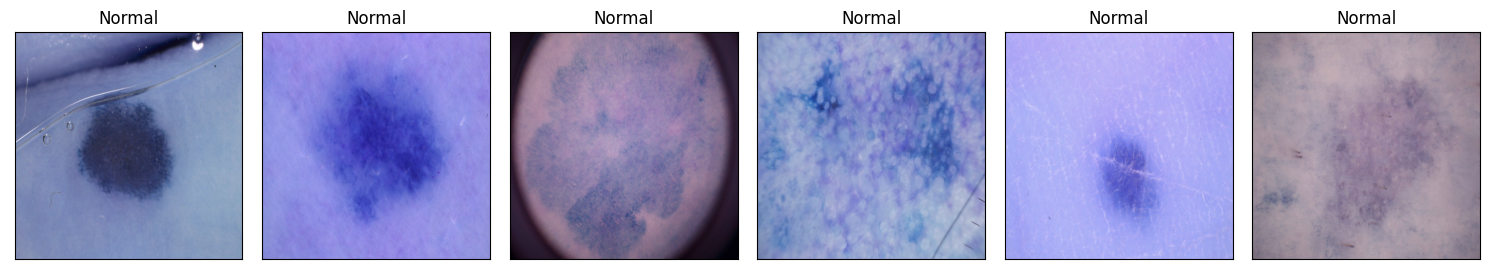

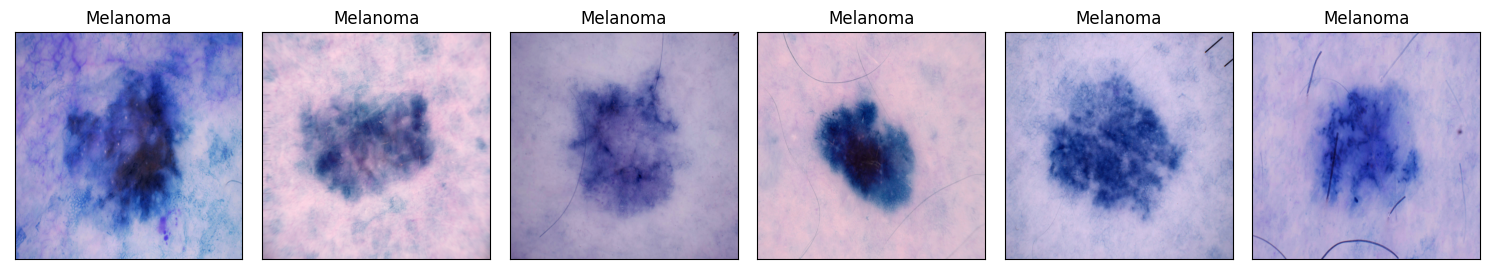

In [27]:
#normal images

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Normal")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

#melonoma images

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(melanoma_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Melanoma")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

### Data Preparation 

In [28]:
# splitting training and validation data
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 13, stratify = df_train['class'])

In [29]:
val_df

,class,image
2036,0,data/train/Normal\ISIC_0031513.jpg
377,0,data/train/Normal\ISIC_0029718.jpg
1357,0,data/train/Normal\ISIC_0030780.jpg
1467,0,data/train/Normal\ISIC_0030899.jpg
1541,0,data/train/Normal\ISIC_0030981.jpg
...,...,...
2232,0,data/train/Normal\ISIC_0031726.jpg
2223,0,data/train/Normal\ISIC_0031716.jpg
2250,0,data/train/Normal\ISIC_0031747.jpg
3310,1,data/train/Malignant\ISIC_0032662.jpg


# Normalization 

In [30]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [32]:
train_datagen = ImageDataGenerator(
                rescale=1/255
                )

val_datagen = ImageDataGenerator(
                rescale=1/255)

In [33]:
train_generator = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col="image",
                    y_col="class",
                    target_size=(150,150),
                    batch_size=32,
                    class_mode="binary",
                    seed=7)

Found 2950 validated image filenames belonging to 2 classes.


In [34]:
val_generator = val_datagen.flow_from_dataframe(
                    val_df,
                    x_col="image",
                    y_col="class",
                    target_size=(150,150),
                    batch_size=32,
                    class_mode="binary",
                    seed=7)

test_generator = val_datagen.flow_from_dataframe(
                    df_test,
                    x_col="image",
                    y_col="class",
                    target_size=(150,150),
                    batch_size=32,
                    class_mode="binary",
                    shuffle=False,
                    seed=7)

Found 738 validated image filenames belonging to 2 classes.
Found 2937 validated image filenames belonging to 2 classes.


# Model 

In [35]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

## Build the classifier CNN model
* Functional layers:
    * Convolution: Add the first layer which is a convolutional layer. Set the number of filters as 16, the shape of each filter as 3x3 and the input shape and the type of image as 150,150,3 i.e. the input is of a 150x150 RGB image and the activation function as relu.
    * Pooling: Add a pooling layer to reduce the total number of nodes for the upcoming layers. It takes a 2x2 matrix thus giving minimum pixel loss and a precise region where the features are located.
    * Flatten: Flattens the pooled images.
    * Dense: add a fully connected layer to feed the images to the output layer. Set the number of nodes as 256, as its a common practice to use a power of 2 and a rectifier function as the activation function, relu.

* Define the output layer. Set number of units to 1 as this is a binary classifier and sigmoid as the activation function.
* Compile the model. Set adam as the optimizer and binary_crossentropy as the loss fucntion, as this is a binary classifier.

In [36]:
# building the cnn

model = Sequential()

#convolution
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(150,150,3)))

#pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#2nd Conv
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))

#2nd pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#3rd conv
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))

#3rd pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#flatten
model.add(Flatten())

#fully connected layer
model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

In [37]:
#compiling
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

The number of parameters are calculated like this:

**1. For Conv. Layers:**   
   no. of parameters = output_channels * (input_channels * window_size + 1)
      
**2. For Dense Layers:**
   no. of parameters = output_size * (input_size + 1)

In [39]:
model_1 = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

Epoch 1/10
93/93 [==============================] - 94s 976ms/step - loss: 0.5073 - accuracy: 0.7468 - val_loss: 0.4542 - val_accuracy: 0.7629
Epoch 2/10
93/93 [==============================] - 85s 915ms/step - loss: 0.4854 - accuracy: 0.7624 - val_loss: 0.4650 - val_accuracy: 0.7873
Epoch 3/10
93/93 [==============================] - 85s 927ms/step - loss: 0.4633 - accuracy: 0.7702 - val_loss: 0.4526 - val_accuracy: 0.7669
Epoch 4/10
93/93 [==============================] - 81s 865ms/step - loss: 0.4360 - accuracy: 0.7854 - val_loss: 0.4273 - val_accuracy: 0.7764
Epoch 5/10
93/93 [==============================] - 84s 905ms/step - loss: 0.4257 - accuracy: 0.7817 - val_loss: 0.4513 - val_accuracy: 0.7561
Epoch 6/10
93/93 [==============================] - 88s 945ms/step - loss: 0.4310 - accuracy: 0.7997 - val_loss: 0.4034 - val_accuracy: 0.7995
Epoch 7/10
93/93 [==============================] - 88s 942ms/step - loss: 0.4049 - accuracy: 0.8041 - val_loss: 0.3990 - val_accuracy: 0.8062

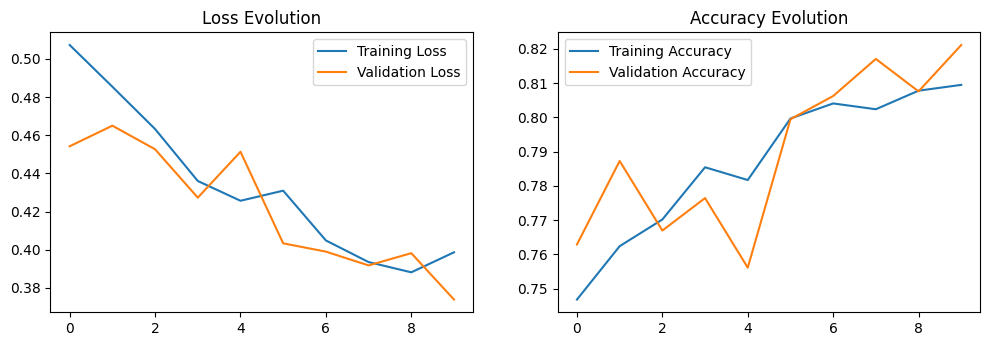

In [40]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(model_1.history["loss"], label="Training Loss")
plt.plot(model_1.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Evolution")

plt.subplot(2,2,2)
plt.plot(model_1.history["accuracy"], label="Training Accuracy")
plt.plot(model_1.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Evolution")

plt.show()

### Performance Metrics

In [41]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

92/92 [==============================] - 40s 438ms/step - loss: 0.2500 - accuracy: 0.8808
Test Accuracy: 88.08%
93/93 [==============================] - 55s 592ms/step - loss: 0.3722 - accuracy: 0.8169
Train Accuracy: 81.69%


In [42]:
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

92/92 [==============================] - 35s 382ms/step


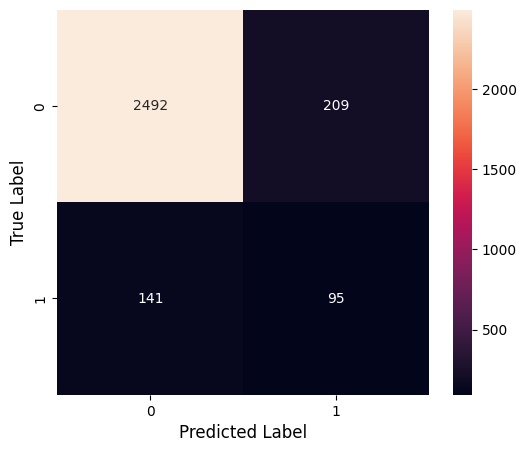

In [43]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,5))

confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

plt.show()

In [44]:
def summarize_classification(y_true, y_pred):
    
    acc = accuracy_score(y_true, y_pred, normalize=True)
    num_acc = accuracy_score(y_true, y_pred, normalize=False)

    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cr = metrics.classification_report(y_true, y_pred) # classificatiob report
    
    print("Test data count: ",len(y_true))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("precision_score : " , prec)
    print("recall_score : ", recall)
    print("class_report : ", cr)
    print()
     


In [33]:
summarize_classification(y_true, y_pred)

Test data count:  2937
accuracy_count :  2606
accuracy_score :  0.8872999659516514
precision_score :  0.35202492211838005
recall_score :  0.4788135593220339
class_report :                precision    recall  f1-score   support

           0       0.95      0.92      0.94      2701
           1       0.35      0.48      0.41       236

    accuracy                           0.89      2937
   macro avg       0.65      0.70      0.67      2937
weighted avg       0.90      0.89      0.89      2937




## Image Augmentation

* Improve the dataset using the ImageDataGenerator method which generate batches of tensor image data with real-time data augmentation. 
    * rescale: rescaling factor. If None or 0, no rescaling is applied, otherwise the data is multiplied by the value provided.
    * shear_range: Shear Intensity
    * zoom_range: Range for random zoom.
    * horizontal_flip: Randomly flip inputs horizontally if true.
* Define the training and test datasets using the flow_from_directory which takes the path to a directory, and generates batches of augmented/normalized data.
    * directory: path to the target directory. It should contain one subdirectory per class.
    * target_size: The dimensions to which all images found will be resized.
    * class_mode: one of "categorical", "binary", "sparse", "input" or None. Determines the type of label arrays that are returned
    * batch_size: size of the batches of data

In [35]:
train_datagen_2 = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                rotation_range=10,
                fill_mode="nearest")

val_datagen = ImageDataGenerator(
              rescale = 1./255)

In [36]:
train_generator_2 = train_datagen_2.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col="image",
    y_col="class",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    seed=7,
    shuffle=False
)

Found 2950 validated image filenames belonging to 2 classes.
Found 738 validated image filenames belonging to 2 classes.
Found 2937 validated image filenames belonging to 2 classes.


### Hyperparameter tuning

In [37]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, min_delta=0.0001, patience=1, verbose=1)

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

In [39]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same",
                 input_shape=(150,150,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.6))
model.add(Dense(1, activation="sigmoid"))

In [40]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)       

### Training the tuned model

In [42]:
model_htuning = model.fit(
            train_generator_2,
            epochs=10,
            validation_data=val_generator,
            callbacks=[lr_reduce,checkpoint])

Epoch 1/10
93/93 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.6620
Epoch 1: val_accuracy improved from -inf to 0.76287, saving model to weights.hdf5
93/93 [==============================] - 410s 4s/step - loss: 0.7150 - accuracy: 0.6620 - val_loss: 0.5727 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 2/10
93/93 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7403
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.76287
93/93 [==============================] - 368s 4s/step - loss: 0.5493 - accuracy: 0.7403 - val_loss: 0.5686 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 3/10
93/93 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7773 
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3: val_accuracy did not improve from 0.76287
93/93 [==============================] - 1225s 13s/step - loss: 0.4861 - accuracy: 0.7773 -

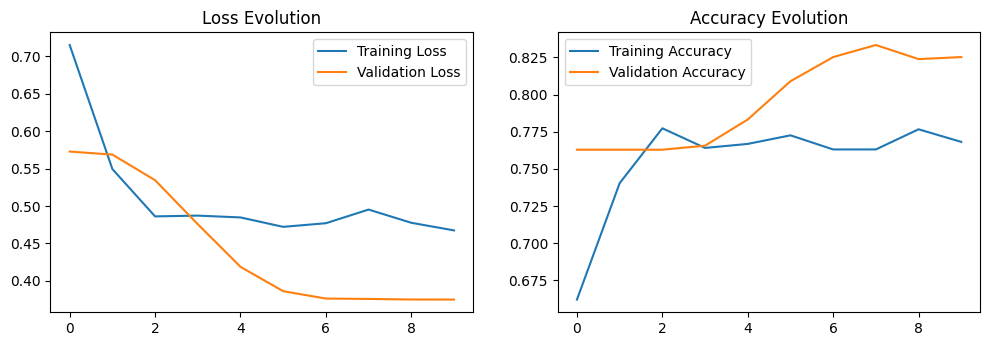

In [43]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_htuning.history['loss'], label='Training Loss')
plt.plot(model_htuning.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_htuning.history['accuracy'], label='Training Accuracy')
plt.plot(model_htuning.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [44]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator_2)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

92/92 [==============================] - 75s 808ms/step - loss: 0.2711 - accuracy: 0.8832
Test Accuracy: 88.32%
93/93 [==============================] - 111s 1s/step - loss: 0.3787 - accuracy: 0.8122
Train Accuracy: 81.22%


In [45]:
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

92/92 [==============================] - 84s 865ms/step


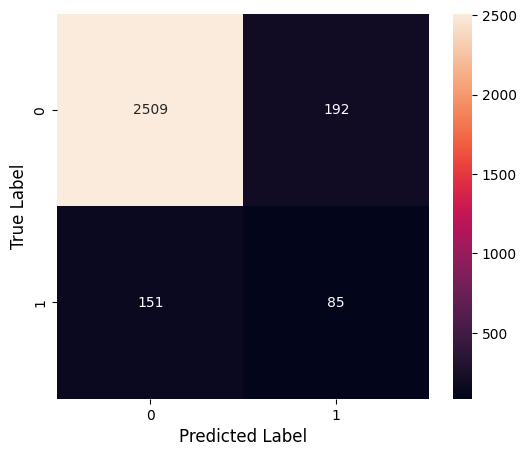

In [46]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,5))

confusion_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [47]:
summarize_classification(y_true, y_pred)

Test data count:  2937
accuracy_count :  2594
accuracy_score :  0.8832141641130405
precision_score :  0.30685920577617326
recall_score :  0.3601694915254237
class_report :                precision    recall  f1-score   support

           0       0.94      0.93      0.94      2701
           1       0.31      0.36      0.33       236

    accuracy                           0.88      2937
   macro avg       0.63      0.64      0.63      2937
weighted avg       0.89      0.88      0.89      2937




### Save the model and weights of the model 

In [45]:
from keras.utils import np_utils

In [46]:
model_json = model.to_json()

In [47]:
with open('melanoma_model.json','w') as json_file:
    json_file.write(model_json)

In [48]:
model.save_weights('melanoma_model.h5')
print("Saved model to disk.")

Saved model to disk.
